In [12]:
import sys
import pandas as pd

sys.path.append('../utils')
from plot_functions_notebook import create_filter_plot, plot_categorical_bar_chart, plot_ratio_by_configurations

# Charger vos données
data = pd.read_excel("../DB/All-at-once_DB.xlsx", sheet_name='screen')

In [13]:
create_filter_plot(data)

Output()

In [3]:
particles = ['N']  # ['N', 'P']  
screens = ['Lead'] # ['Concrete', 'Steel', 'Water', 'Lead']
cases = ['C1 [U(4.95)O2F2 (H/235U = 410)]']  # ['C1 [U(4.95)O2F2 (H/235U = 410)]', 'C4 [U(93.2) (H/235U = 0)]']
codes = ['MCNP 6.1']  #  ['MCNP 6.1', 'COG 11.2', 'SCALE 6.2.2']
thicknesses = [] # [1, 5, 10, 20]

In [ ]:
particles = ['P']  # ['N', 'P']  
screens = ['Lead'] # ['Concrete', 'Steel', 'Water', 'Lead']
cases = ['C1 [U(4.95)O2F2 (H/235U = 410)]']  # ['C1 [U(4.95)O2F2 (H/235U = 410)]', 'C4 [U(93.2) (H/235U = 0)]']
codes = ['MCNP 6.1']  #  ['MCNP 6.1', 'COG 11.2', 'SCALE 6.2.2']
thicknesses = [5, 10, 20] # [1, 5, 10, 20]

In [4]:
plot_ratio_by_configurations(data, particles, screens, cases, codes, thicknesses)

In [6]:
plot_categorical_bar_chart(data, particles, screens, cases, codes, thicknesses)

In [2]:
def filter_dataframe(data, particles, screens, cases, codes, thicknesses):
    # Apply the filters step by step, checking if thicknesses list is empty or not
    filtered_data = data[
        (data['Particle'].isin(particles)) &
        (data['Screen'].isin(screens)) &
        (data['Case'].isin(cases)) &
        (data['Code'].isin(codes))
    ]
    
    if thicknesses:  # Only apply thickness filter if it's not empty
        filtered_data = filtered_data[filtered_data['Thickness (cm)'].isin(thicknesses)]
    
    return filtered_data




In [3]:
# Define your filter criteria
particles = ['N']  # Example: ['N', 'P']  
screens = ['None']  # Example: ['Concrete', 'Steel', 'Water', 'Lead']
cases = ['C1 [U(4.95)O2F2 (H/235U = 410)]']  # Example: ['C1 [U(4.95)O2F2 (H/235U = 410)]', 'C4 [U(93.2) (H/235U = 0)]']
codes = ['MCNP 6.1']  # Example: ['MCNP 6.1', 'COG 11.2', 'SCALE 6.2.2']
thicknesses = []  # Example: [1, 5, 10, 20]

# Apply the filter
filtered_data = filter_dataframe(data, particles, screens, cases, codes, thicknesses)

# Display the filtered data
filtered_data

,Fissile,Case,Code,Library,Flux-to-dose conversion factor,Screen,Thickness (cm),Particle,Distance (m),Dose (Gy),1s uncertainty
2184,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,N,1,9.199573e+00,0.0017
2185,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,N,2,3.152653e+00,0.0025
2186,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,N,5,6.201317e-01,0.0036
2187,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,N,10,1.629825e-01,0.0053
2188,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,N,20,4.239522e-02,0.0084
2189,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,N,50,7.159838e-03,0.0137
2190,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,N,100,1.740656e-03,0.0156
2191,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,N,200,3.338229e-04,0.0128
2192,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,N,300,1.031012e-04,0.0176
2193,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,N,500,1.542779e-05,0.0127


In [13]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add scatter plot with dose vs distance
fig.add_trace(go.Scatter(
    x=filtered_data['Distance (m)'],
    y=filtered_data['Dose (Gy)'],
    mode='lines+markers',
    name='Dose vs Distance'
))

# Update layout for log scale and axis labels
fig.update_layout(
    title="Dose vs. Distance",
    xaxis_title="Distance (m) [Log Scale]",
    yaxis_title="Dose (Gy) [Log Scale]",
    xaxis_type="log",
    yaxis_type="log",
    showlegend=True
)

# Show the plot
fig.show()


In [5]:
# Define your filter criteria
particles = ['N']  # Example: ['N', 'P']  
screens = ['None']  # Example: ['Concrete', 'Steel', 'Water', 'Lead']
cases = ['C1 [U(4.95)O2F2 (H/235U = 410)]']  # Example: ['C1 [U(4.95)O2F2 (H/235U = 410)]', 'C4 [U(93.2) (H/235U = 0)]']
codes = ['MCNP 6.1']  # Example: ['MCNP 6.1', 'COG 11.2', 'SCALE 6.2.2']
thicknesses = []  # Example: [1, 5, 10, 20]

# Apply the filter
filtered_data = filter_dataframe(data, particles, screens, cases, codes, thicknesses)

# Display the filtered data
filtered_data

,Fissile,Case,Code,Library,Flux-to-dose conversion factor,Screen,Thickness (cm),Particle,Distance (m),Dose (Gy),1s uncertainty
2184,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,N,1,9.199573e+00,0.0017
2185,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,N,2,3.152653e+00,0.0025
2186,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,N,5,6.201317e-01,0.0036
2187,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,N,10,1.629825e-01,0.0053
2188,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,N,20,4.239522e-02,0.0084
2189,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,N,50,7.159838e-03,0.0137
2190,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,N,100,1.740656e-03,0.0156
2191,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,N,200,3.338229e-04,0.0128
2192,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,N,300,1.031012e-04,0.0176
2193,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,N,500,1.542779e-05,0.0127


In [16]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def fit_data(xdata, ydata, plot=False):
    """
    Fits the model y = A * x^(-k) * exp(-b * x) to the provided data.

    Parameters:
    - xdata: numpy array of x values in meters
    - ydata: numpy array of corresponding y values
    - plot: boolean indicating whether to display the fit plot

    Returns:
    - A_opt: optimal value of parameter A
    - k_opt: optimal value of parameter k
    - b_opt: optimal value of parameter b
    - R_squared: coefficient of determination R²
    """
    # Ensure xdata and ydata are numpy arrays
    xdata = np.array(xdata)  # xdata in meters
    ydata = np.array(ydata)
    
    # Take the natural logarithm of y data
    ln_ydata = np.log(ydata)
    
    # Model function for the logarithms
    def log_model_func(x, lnA, k, b):
        return lnA - k * np.log(x) - b * x
    
    # Initial estimates from linear regression
    ln_x = np.log(xdata)
    X = np.column_stack((np.ones(len(ln_x)), ln_x, xdata))
    beta, residuals, rank, s = np.linalg.lstsq(X, ln_ydata, rcond=None)
    lnA_init = beta[0]
    k_init = -beta[1]
    b_init = -beta[2]
    
    initial_guess = [lnA_init, k_init, b_init]
    
    # Fit the model to the logarithmic data
    popt, pcov = curve_fit(log_model_func, xdata, ln_ydata, p0=initial_guess, maxfev=10000)
    
    # Extract optimal parameters
    lnA_opt, k_opt, b_opt = popt
    A_opt = np.exp(lnA_opt)
    
    # Compute fitted values with optimal parameters
    ln_y_fit = log_model_func(xdata, lnA_opt, k_opt, b_opt)
    y_fit = np.exp(ln_y_fit)
    
    # Calculate the coefficient of determination R²
    ss_res = np.sum((ln_ydata - ln_y_fit) ** 2)
    ss_tot = np.sum((ln_ydata - np.mean(ln_ydata)) ** 2)
    R_squared = 1 - (ss_res / ss_tot)
    
    # # Display results
    # print(f"Optimal parameters after fitting:")
    # print(f"A = {A_opt}")
    # print(f"k = {k_opt}")
    # print(f"b = {b_opt}")
    # print(f"Coefficient of determination R² = {R_squared}\n")
    
    # Optionally, display the plot
    if plot:
        plt.figure(figsize=(10, 6))
        plt.loglog(xdata, ydata, 'bo', label='Experimental data')
        plt.loglog(xdata, y_fit, 'r-', label='Fitted model')
        plt.xlabel('x (meters)')
        plt.ylabel('y')
        plt.title('Model fit to data')
        plt.legend()
        plt.grid(True, which="both", ls="--")
        
        # Add the formula with parameter values and R² to the plot
        formula_text = (f"y = {A_opt:.3e} * x^(-{k_opt:.3f}) * exp(-{b_opt:.3e} * x)\n"
                        f"$R^2$ = {R_squared:.6f}")
        plt.text(0.05, 0.1, formula_text, transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='white', alpha=0.5))
        
        plt.show()
    
    return A_opt, k_opt, b_opt, R_squared


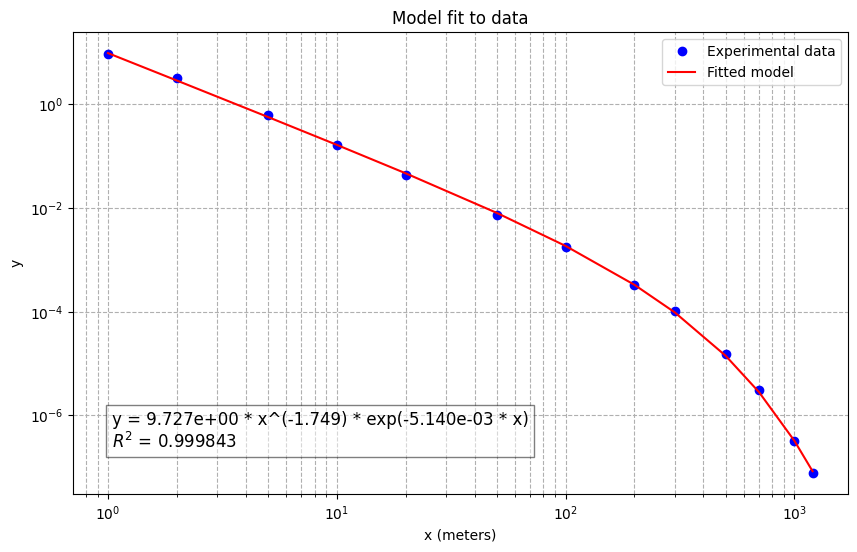

A = 9.726853779490932
k = 1.7487543240381649
b = 0.005139970499808651
R² = 0.9998425681064602


In [17]:
# Experimental data (xdata in meters)
xdata = np.array([1, 2, 5, 10, 20, 50, 100,
                  200, 300, 500, 700, 1000, 1200])  # xdata in meters
ydata = np.array([9.199572953, 3.15265299, 0.620131736, 0.162982509,
                  0.042395217, 0.007159838, 0.001740656, 0.000333823,
                  0.000103101, 1.54e-05, 3.05e-06, 3.23e-07, 7.71e-08])

# Call the fit function with plot=True
A_opt, k_opt, b_opt, R_squared = fit_data(xdata, ydata, plot=True)

print(f"A = {A_opt}")
print(f"k = {k_opt}")
print(f"b = {b_opt}")
print(f"R² = {R_squared}")


In [1]:
import pandas as pd
import plotly.graph_objs as go

def filter_dataframe(data, particles, screens, cases, codes, thicknesses, plot=False):
    # Apply the filters
    filtered_data = data[
        (data['Particle'].isin(particles)) &
        (data['Screen'].isin(screens)) &
        (data['Case'].isin(cases)) &
        (data['Code'].isin(codes))
    ]
    
    if thicknesses:  # Only apply thickness filter if it's not empty
        filtered_data = filtered_data[filtered_data['Thickness (cm)'].isin(thicknesses)]
    
    # **Create a copy to avoid SettingWithCopyWarning**
    filtered_data = filtered_data.copy()
    
    # Calculate absolute uncertainties if not already present
    if "Absolute Uncertainty" not in filtered_data.columns:
        filtered_data["Absolute Uncertainty"] = filtered_data["1s uncertainty"] * filtered_data["Dose (Gy)"]
    
    # Add 'Filter Combo' column if not already present
    if 'Filter Combo' not in filtered_data.columns:
        filtered_data['Filter Combo'] = filtered_data.apply(
            lambda row: f"{row['Particle']}_{row['Screen']}_{row['Code']}_{row['Case']}_{row['Thickness (cm)']}", axis=1)
    
    if plot:
        # Create the plot
        fig = go.Figure()
        fig.update_layout(
            title="Dose vs. Distances",
            xaxis_title="Distance (m) [Log]",
            yaxis_title="Dose (Gy) [Log]",
            legend_title="",
            xaxis={'type': 'log'},
            yaxis={'type': 'log', 'tickformat': '.2e'},
            showlegend=True
        )
        
        for combo in filtered_data['Filter Combo'].unique():
            df_subset = filtered_data[filtered_data['Filter Combo'] == combo]
            fig.add_trace(go.Scatter(
                x=df_subset["Distance (m)"],
                y=df_subset["Dose (Gy)"],
                mode='lines+markers',
                name=combo,
                line=dict(dash='dash'),
                error_y=dict(
                    type='data',
                    array=2 * df_subset["Absolute Uncertainty"],
                    visible=True
                )
            ))
        
        fig.show()
    
    return filtered_data


In [3]:
# Charger vos données
data = pd.read_excel("../DB/All-at-once_DB.xlsx", sheet_name='screen')

# Define your filter criteria
particles = ['P']  # Example: ['N', 'P']
screens = ['None']  # Example: ['Concrete', 'Steel', 'Water', 'Lead']
cases = ['C1 [U(4.95)O2F2 (H/235U = 410)]']  # Add more cases as needed
codes = ['MCNP 6.1']  # Add more codes as needed
thicknesses = []  # Example: [1, 5, 10, 20]

# Apply the filter and plot the data
filtered_data = filter_dataframe(
    data,
    particles,
    screens,
    cases,
    codes,
    thicknesses,
    plot=True  # Set to True to display the plot
)

# Display the filtered data
filtered_data


,Fissile,Case,Code,Library,Flux-to-dose conversion factor,Screen,Thickness (cm),Particle,Distance (m),Dose (Gy),1s uncertainty,Absolute Uncertainty,Filter Combo
2197,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,P,1,5.210193e+00,0.0008,4.168154e-03,P_None_MCNP 6.1_C1 [U(4.95)O2F2 (H/235U = 410)]_0
2198,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,P,2,1.680681e+00,0.0011,1.848749e-03,P_None_MCNP 6.1_C1 [U(4.95)O2F2 (H/235U = 410)]_0
2199,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,P,5,3.203193e-01,0.0017,5.445428e-04,P_None_MCNP 6.1_C1 [U(4.95)O2F2 (H/235U = 410)]_0
2200,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,P,10,8.436647e-02,0.0023,1.940429e-04,P_None_MCNP 6.1_C1 [U(4.95)O2F2 (H/235U = 410)]_0
2201,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,P,20,2.126016e-02,0.0032,6.803251e-05,P_None_MCNP 6.1_C1 [U(4.95)O2F2 (H/235U = 410)]_0
2202,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,P,50,3.247308e-03,0.0054,1.753546e-05,P_None_MCNP 6.1_C1 [U(4.95)O2F2 (H/235U = 410)]_0
2203,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,P,100,7.140783e-04,0.0073,5.212771e-06,P_None_MCNP 6.1_C1 [U(4.95)O2F2 (H/235U = 410)]_0
2204,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,P,200,1.290771e-04,0.0094,1.213325e-06,P_None_MCNP 6.1_C1 [U(4.95)O2F2 (H/235U = 410)]_0
2205,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,P,300,4.017847e-05,0.0661,2.655797e-06,P_None_MCNP 6.1_C1 [U(4.95)O2F2 (H/235U = 410)]_0
2206,U,C1 [U(4.95)O2F2 (H/235U = 410)],MCNP 6.1,ENDF/B-VII.1,ANSI/HPS N13.3,None,0,P,500,6.578409e-06,0.0161,1.059124e-07,P_None_MCNP 6.1_C1 [U(4.95)O2F2 (H/235U = 410)]_0
